# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=70,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-03-50/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4966 | MulticlassF1Score=0.0611
Batch-30 : CrossEntropyLoss=2.4850 | MulticlassF1Score=0.1588
Batch-45 : CrossEntropyLoss=2.4724 | MulticlassF1Score=0.1928
Batch-60 : CrossEntropyLoss=2.4383 | MulticlassF1Score=0.2237
Batch-75 : CrossEntropyLoss=2.4372 | MulticlassF1Score=0.2592
Batch-90 : CrossEntropyLoss=2.4255 | MulticlassF1Score=0.2831
Batch-105: CrossEntropyLoss=2.4405 | MulticlassF1Score=0.3021
Batch-120: CrossEntropyLoss=2.4136 | MulticlassF1Score=0.3275
Batch-135: CrossEntropyLoss=2.3871 | MulticlassF1Score=0.3488
Batch-150: CrossEntropyLoss=2.3807 | MulticlassF1Score=0.3709
Batch-165: CrossEntropyLoss=2.3917 | MulticlassF1Score=0.3904
Batch-180: CrossEntropyLoss=2.3655 | MulticlassF1Score=0.4082
Batch-195: CrossEntropyLoss=2.3509 | MulticlassF1Score=0.4274
Batch-210: CrossEntropyLoss=2.3661 | MulticlassF1Score=0.4448
Batch-225: CrossEntropyLoss=2.3557 | MulticlassF1Score=0.4595
Batch-226: CrossEntropyLoss=2.3471 | MulticlassF1Score=0.4601

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3424 | MulticlassF1Score=0.6849
Batch-30 : CrossEntropyLoss=2.3406 | MulticlassF1Score=0.6768
Batch-45 : CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6756
Batch-60 : CrossEntropyLoss=2.3480 | MulticlassF1Score=0.6762
Batch-63 : CrossEntropyLoss=2.3443 | MulticlassF1Score=0.6763

Training   : Mean CrossEntropyLoss = 2.4251 | Mean MulticlassF1Score = 0.2983
Validation : Mean CrossEntropyLoss = 2.3488 | Mean MulticlassF1Score = 0.6793

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3619 | MulticlassF1Score=0.6700
Batch-30 : CrossEntropyLoss=2.3616 | MulticlassF1Score=0.6682
Batch-45 : CrossEntropyLoss=2.3425 | MulticlassF1Score=0.6835
Batch-60 : CrossEntropyLoss=2.3282 | MulticlassF1Score=0.6952
Batch-75 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7048
Batch-90 : CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7148
Batch-105: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7242
Batch-120: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7314
Batch-135: CrossEntropyLoss=2.3201 | MulticlassF1Score=0.7375
Batch-150: CrossEntropyLoss=2.3304 | MulticlassF1Score=0.7416
Batch-165: CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7458
Batch-180: CrossEntropyLoss=2.3219 | MulticlassF1Score=0.7499
Batch-195: CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7527
Batch-210: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7553
Batch-225: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7579
Batch-226: CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7580

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7791
Batch-30 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7889
Batch-45 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7890
Batch-60 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7908
Batch-63 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7912

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3240 | Mean MulticlassF1Score = 0.7193
Validation : Mean CrossEntropyLoss = 2.3131 | Mean MulticlassF1Score = 0.7855

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.7962
Batch-30 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7961
Batch-45 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7949
Batch-60 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.7933
Batch-75 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7939
Batch-90 : CrossEntropyLoss=2.3251 | MulticlassF1Score=0.7936
Batch-105: CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7925
Batch-120: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7920
Batch-135: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7936
Batch-150: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7954
Batch-165: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.7973
Batch-180: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7989
Batch-195: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8004
Batch-210: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8015
Batch-225: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8025
Batch-226: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8026

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8122
Batch-30 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8132
Batch-45 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8152
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8144
Batch-63 : CrossEntropyLoss=2.3179 | MulticlassF1Score=0.8135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3093 | Mean MulticlassF1Score = 0.7956
Validation : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8140

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8080
Batch-30 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8081
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8125
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8115
Batch-75 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8139
Batch-90 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8143
Batch-105: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8140
Batch-120: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8152
Batch-135: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8161
Batch-150: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8169
Batch-165: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8179
Batch-180: CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8182
Batch-195: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8188
Batch-210: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8201
Batch-225: CrossEntropyLoss=2.3157 | MulticlassF1Score=0.8201
Batch-226: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8202

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8218
Batch-30 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8232
Batch-45 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8253
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8275
Batch-63 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3037 | Mean MulticlassF1Score = 0.8147
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8241

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8311
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8274
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8294
Batch-60 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8310
Batch-75 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8301
Batch-90 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8308
Batch-105: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8310
Batch-120: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8313
Batch-135: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8313
Batch-150: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8316
Batch-165: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8314
Batch-180: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8309
Batch-195: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8306
Batch-210: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8306
Batch-225: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8305
Batch-226: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8304

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8254
Batch-30 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8289
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8289
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8275
Batch-63 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8284

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8307
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8287

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8299
Batch-30 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8304
Batch-45 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8336
Batch-60 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8344
Batch-75 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8377
Batch-90 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8392
Batch-105: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8403
Batch-120: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8409
Batch-135: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8411
Batch-150: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8422
Batch-165: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8437
Batch-180: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8447
Batch-195: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8450
Batch-210: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8460
Batch-225: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8464
Batch-226: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8490
Batch-30 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8524
Batch-45 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8528
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8523
Batch-63 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8529

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2956 | Mean MulticlassF1Score = 0.8394
Validation : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8501

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8579
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8577
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8577
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8592
Batch-75 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8603
Batch-90 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8632
Batch-105: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8658
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8680
Batch-135: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8698
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8713
Batch-165: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8725
Batch-180: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8734
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8741
Batch-210: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8745
Batch-225: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8752
Batch-226: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8752

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8859
Batch-30 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8820
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8825
Batch-60 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8840
Batch-63 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8836

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2869 | Mean MulticlassF1Score = 0.8663
Validation : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8845

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8902
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8919
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8903
Batch-75 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8906
Batch-90 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8899
Batch-105: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8887
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8889
Batch-135: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8887
Batch-150: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8878
Batch-165: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8877
Batch-180: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8879
Batch-195: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8884
Batch-210: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8886
Batch-225: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8884
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8884

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8865
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8851
Batch-63 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8852

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8891
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8872

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8944
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8910
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8921
Batch-90 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8928
Batch-105: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8936
Batch-120: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8937
Batch-150: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8931
Batch-165: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8926
Batch-180: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8925
Batch-195: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8923
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8919
Batch-225: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8918
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8918

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8893
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8866
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8867
Batch-63 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8926
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8874

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8949
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8934
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8951
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8945
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8946
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8948
Batch-105: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8947
Batch-120: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8942
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8939
Batch-150: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8939
Batch-165: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8936
Batch-180: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8935
Batch-195: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8933
Batch-210: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8934
Batch-225: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8937
Batch-226: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8936

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8831
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8868
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8877
Batch-63 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8873

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8942
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8866

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8983
Batch-45 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8959
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8954
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8954
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8948
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.8959
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8965
Batch-135: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8962
Batch-150: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8960
Batch-165: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8960
Batch-180: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8964
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8964
Batch-210: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8963
Batch-225: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8960
Batch-226: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8960

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8828
Batch-30 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8857
Batch-45 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8869
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8874
Batch-63 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8972
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8846

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9005
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9011
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9003
Batch-75 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9004
Batch-90 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8993
Batch-105: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8991
Batch-120: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8984
Batch-135: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8978
Batch-150: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8976
Batch-165: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8978
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8974
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8973
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8973
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8970
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8971

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8885
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8891
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8891

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8989
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8874

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9037
Batch-30 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8990
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9051
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9080
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9101
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9118
Batch-105: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9128
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9137
Batch-135: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9144
Batch-150: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9153
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9160
Batch-180: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9160
Batch-195: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9164
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9167
Batch-225: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9171
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9171

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9098
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9103
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9114
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9113

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9114
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9110

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9243
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9232
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9233
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9226
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9223
Batch-135: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9223
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9229
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9236
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9238
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9244
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9246
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9248
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9248

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9170
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9185
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9190
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9236
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9178

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9308
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9312
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9310
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9306
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9293
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9297
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9299
Batch-135: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9299
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9302
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9299
Batch-180: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9301
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9303
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9304
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9304
Batch-226: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9304

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9171
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9175
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9187
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9192

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9301
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9185

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9301
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9319
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9333
Batch-75 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9338
Batch-90 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9340
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9333
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9338
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9334
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9334
Batch-165: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9334
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9335
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9335
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9332
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9331
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9203

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9357
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9357
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9351
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9348
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9354
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9353
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9359
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9357
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9355
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9351
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9351
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9352
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9352
Batch-225: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9350
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9350

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9354
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9226

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9342
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9354
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9364
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9369
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9371
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9371
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9367
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9364
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9364
Batch-225: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9362
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9207
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9360
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9210

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9375
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9373
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9372
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9363
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9363
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9369
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9369
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9369
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9262
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9378
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9247

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9390
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9387
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9375
Batch-90 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9369
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9370
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9372
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9373
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9375
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9375
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9373
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9374

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9209

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9389
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9391
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9387
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9383
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9394
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9227

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9396
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9393
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9388
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9390
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9389
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9236

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9404
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9404
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9403
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9405
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9401
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9404
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9404
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9401
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9249

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9411
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9409
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9410
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9408
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9407
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9224
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9232

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9420
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9423
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9418
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9415
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9411
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9253

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9425
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9428
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9426
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9426

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9246
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9427
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9237

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9442
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9248

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9428
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9428
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9256

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9268
Patience = 1/50❗

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9448
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9443
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9237

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9494
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9507
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9518
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9528
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9536
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9545
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9552
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9561
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9561

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2611 | Mean MulticlassF1Score = 0.9493
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9436

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9659
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9652
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9651
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9649
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9649
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9645
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9448
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9446

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9648
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9464

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9650
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9644
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9643
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9643

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9453

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9461

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9656
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9653
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9653
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9649
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9648
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9457

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9655
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9656
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9656
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9652
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9655
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9655

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9660
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9463

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9654
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9654
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9656
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9448
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9448

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9449

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9662
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9444

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9465

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9727
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9460

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9676
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9461

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9675
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9459

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9451
Patience = 2/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9465

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9471
Patience = 3/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9717
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9471

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9486

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9694
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9479

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9449

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9475

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9476

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9488
Patience = 4/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9458

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9474

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9468
Patience = 5/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2569
Best CrossEntropyLoss training    : 2.2639
Best MulticlassF1Score validation : 0.9693
Best MulticlassF1Score validation : 0.9458
Training duration                 : 1.9933 minutes.
Training date                     : 2022-10-19 12:42:18.070528+08:00


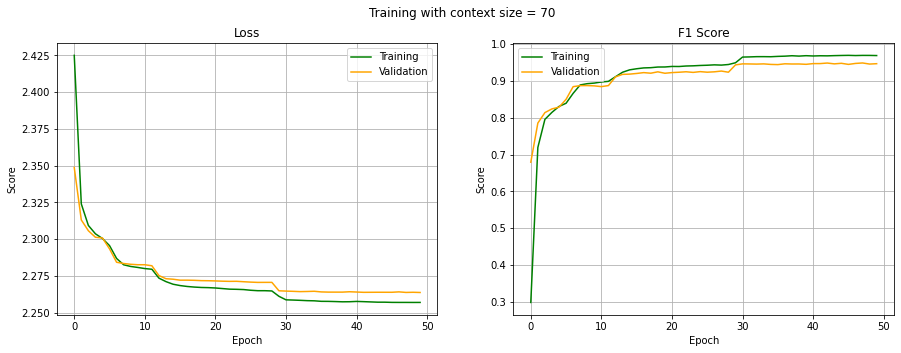

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9693, device='cuda:0'),
 tensor(0.9474, device='cuda:0'),
 tensor(0.9428, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9693, device='cuda:0'),
 tensor(0.9474, device='cuda:0'),
 tensor(0.9428, device='cuda:0'))

## Heatmap

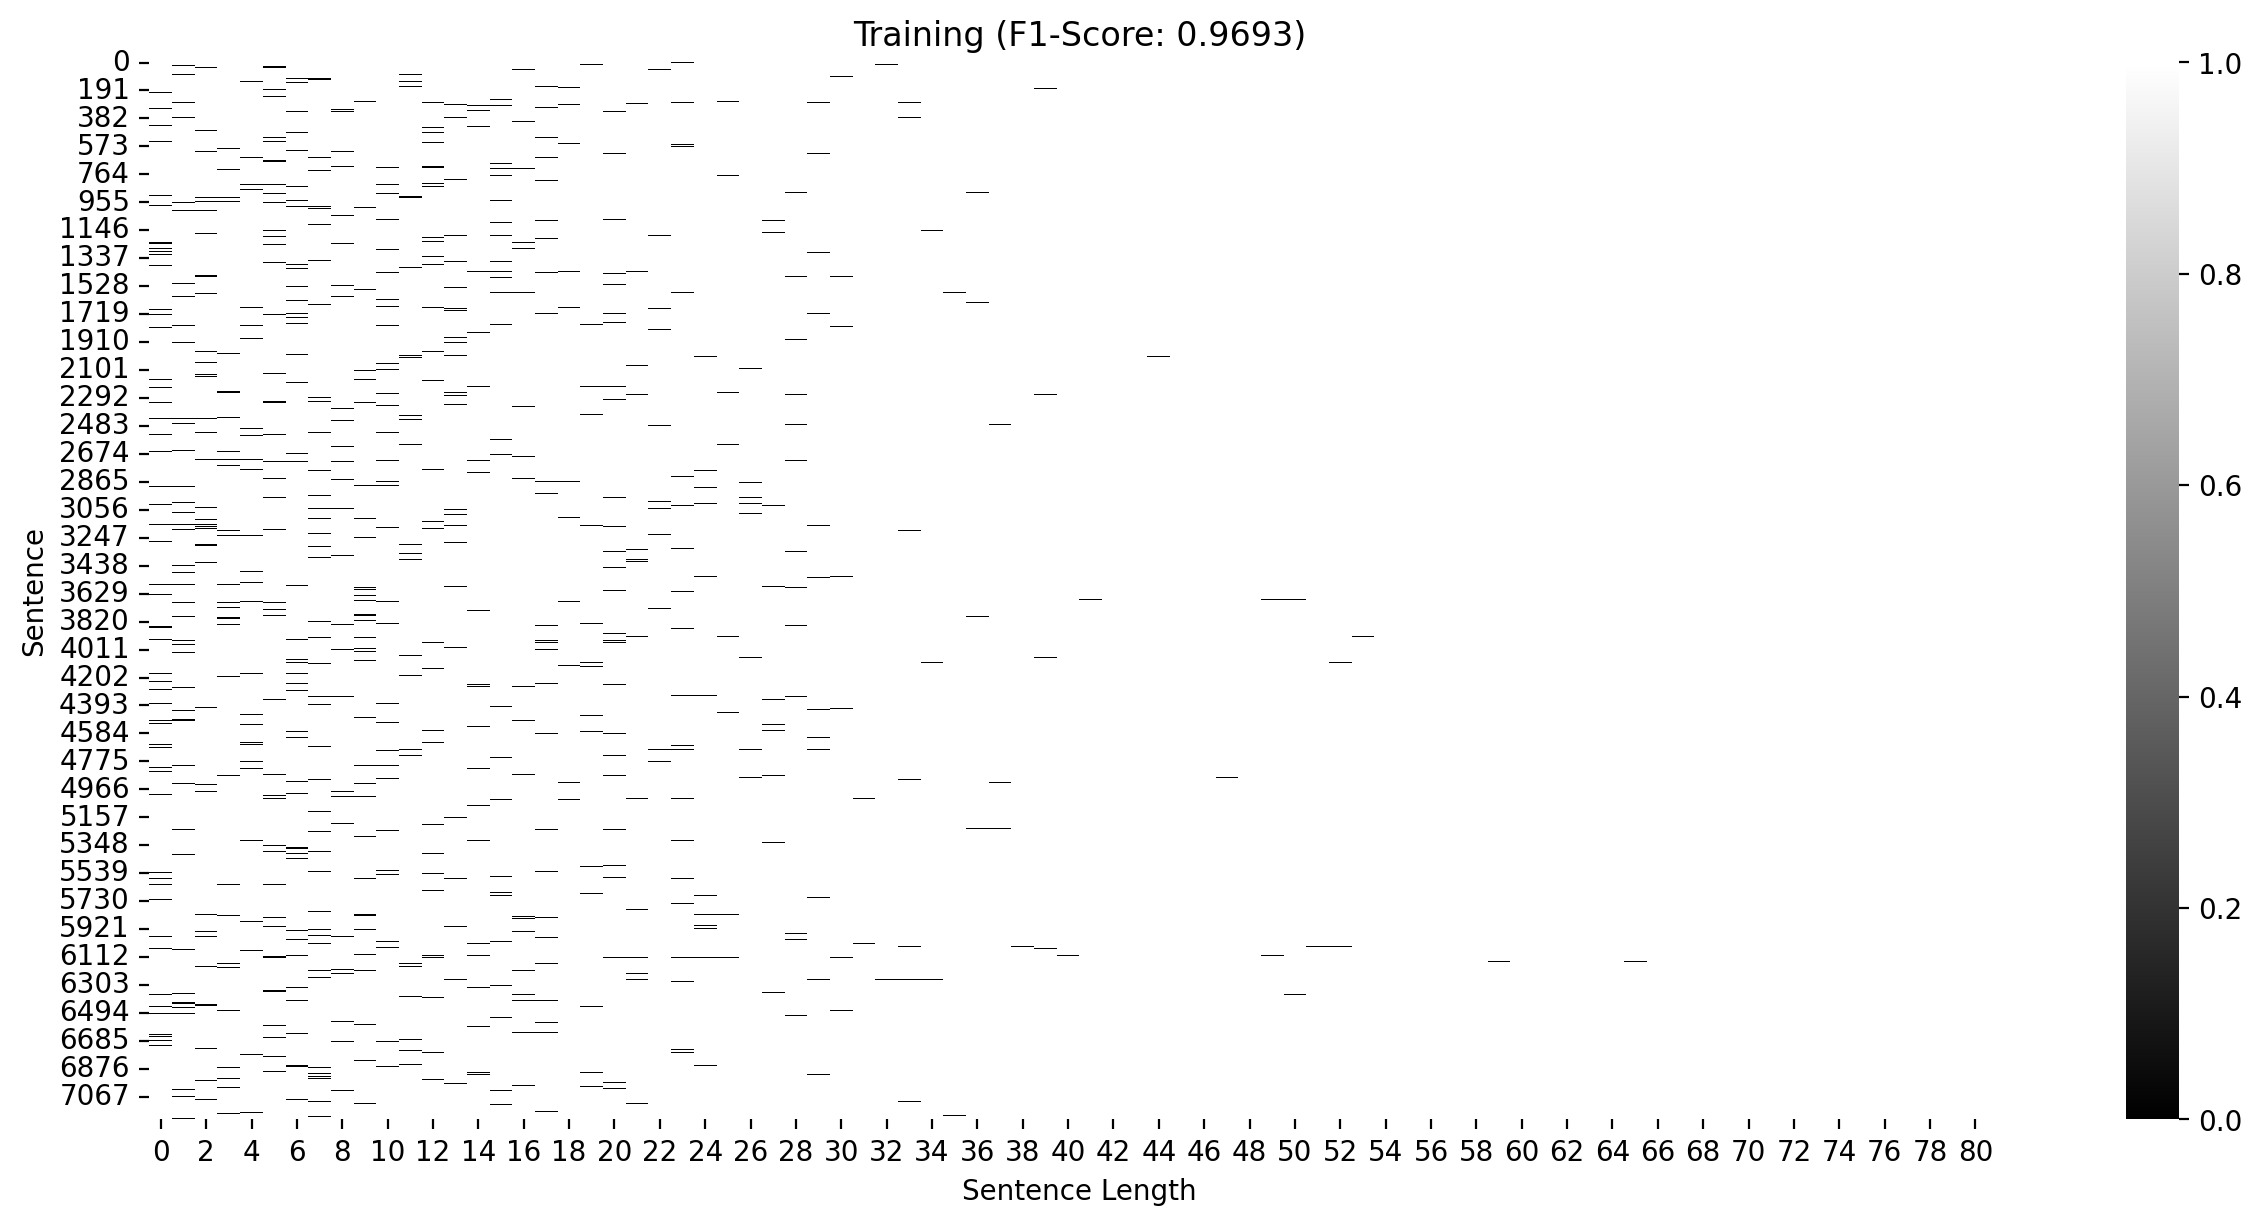

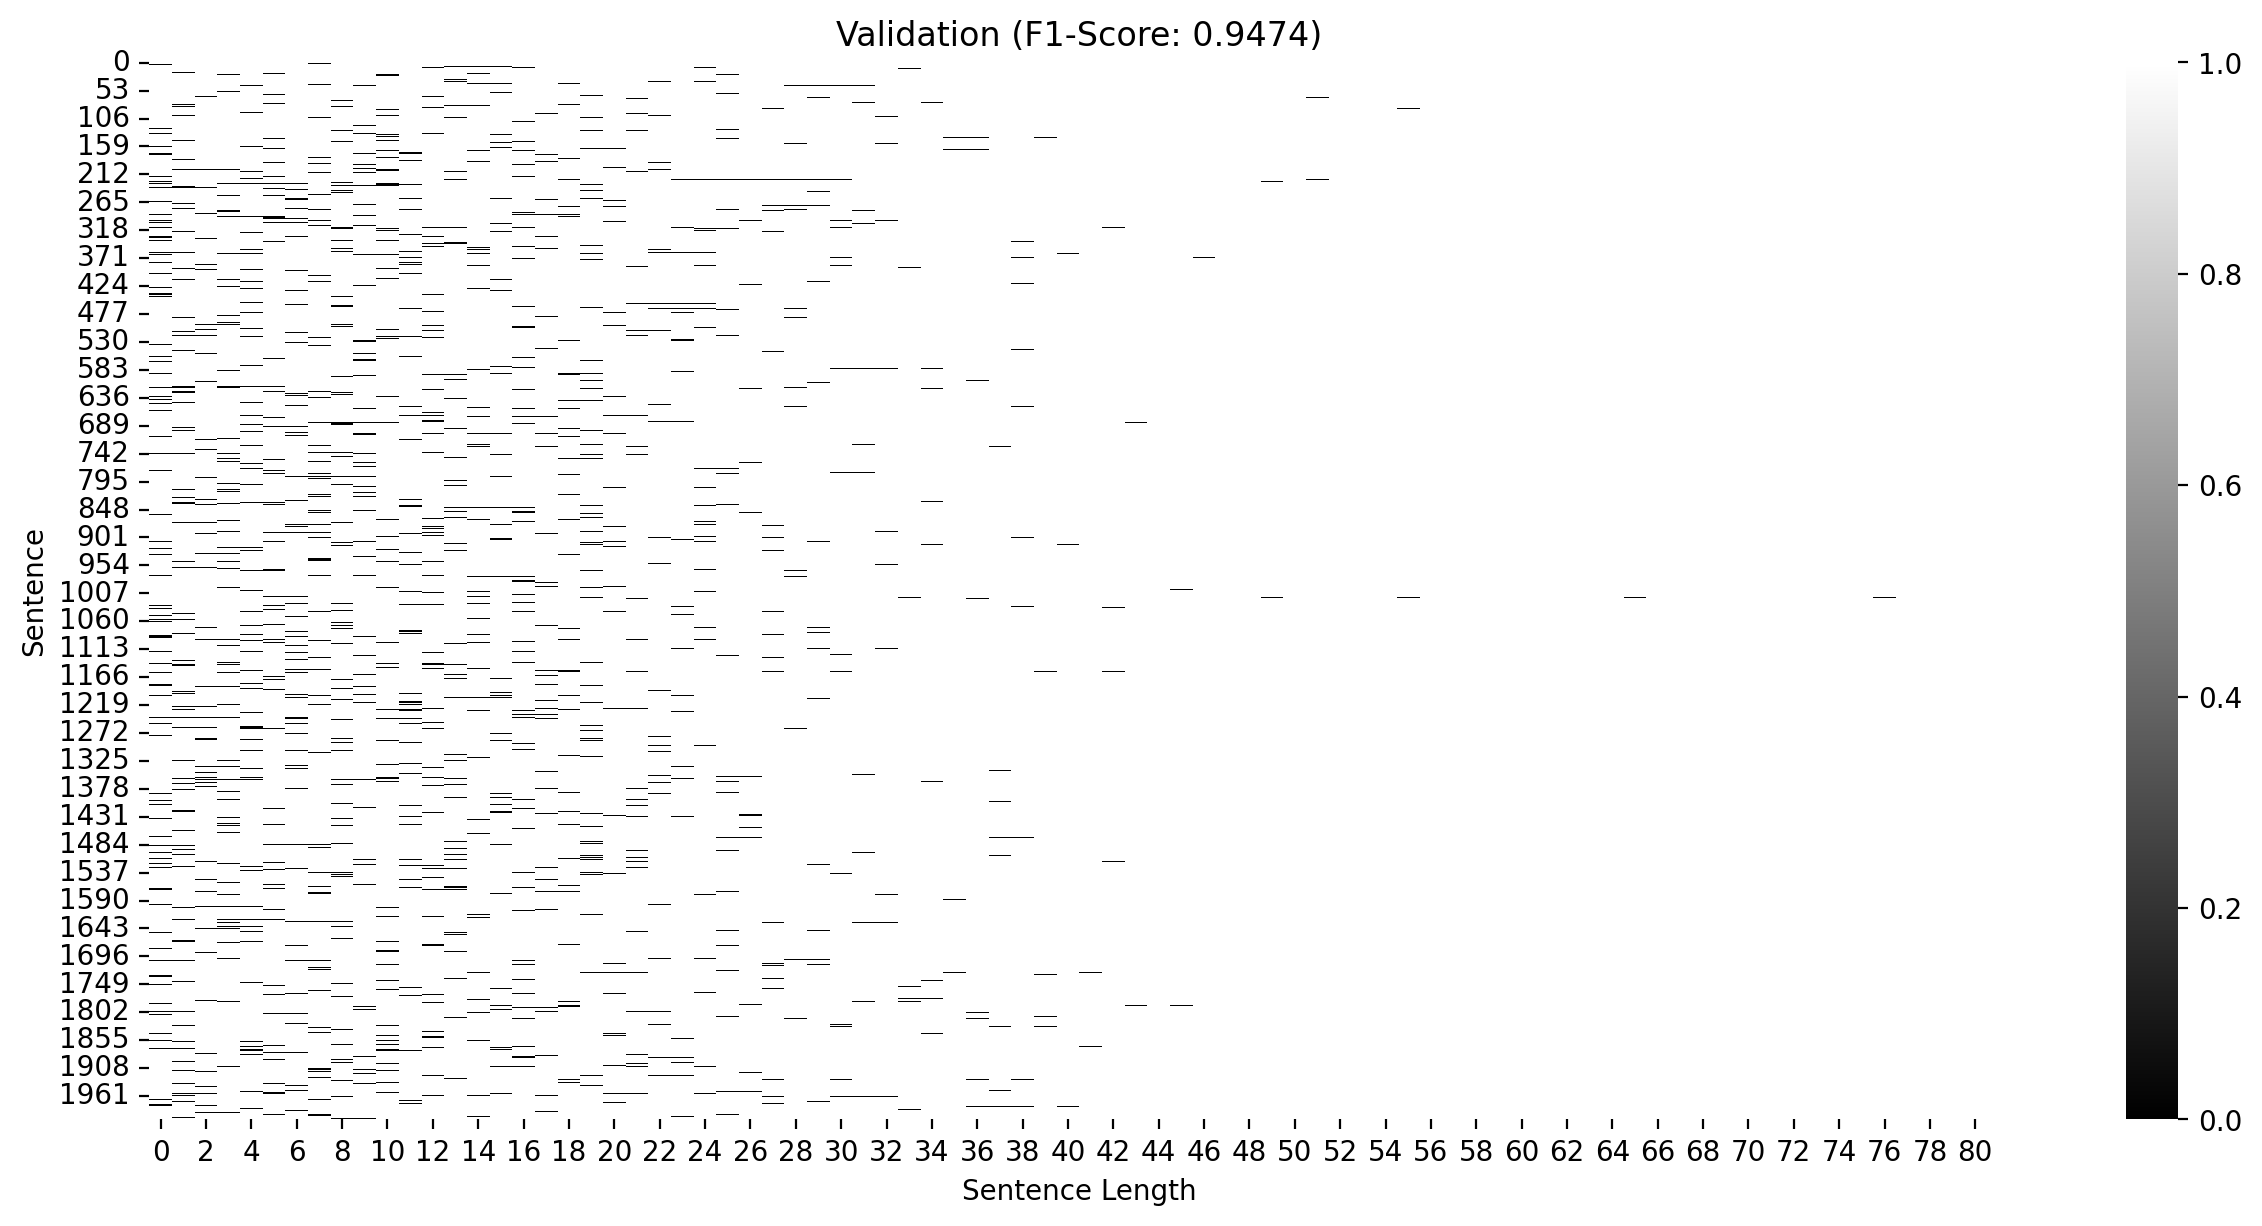

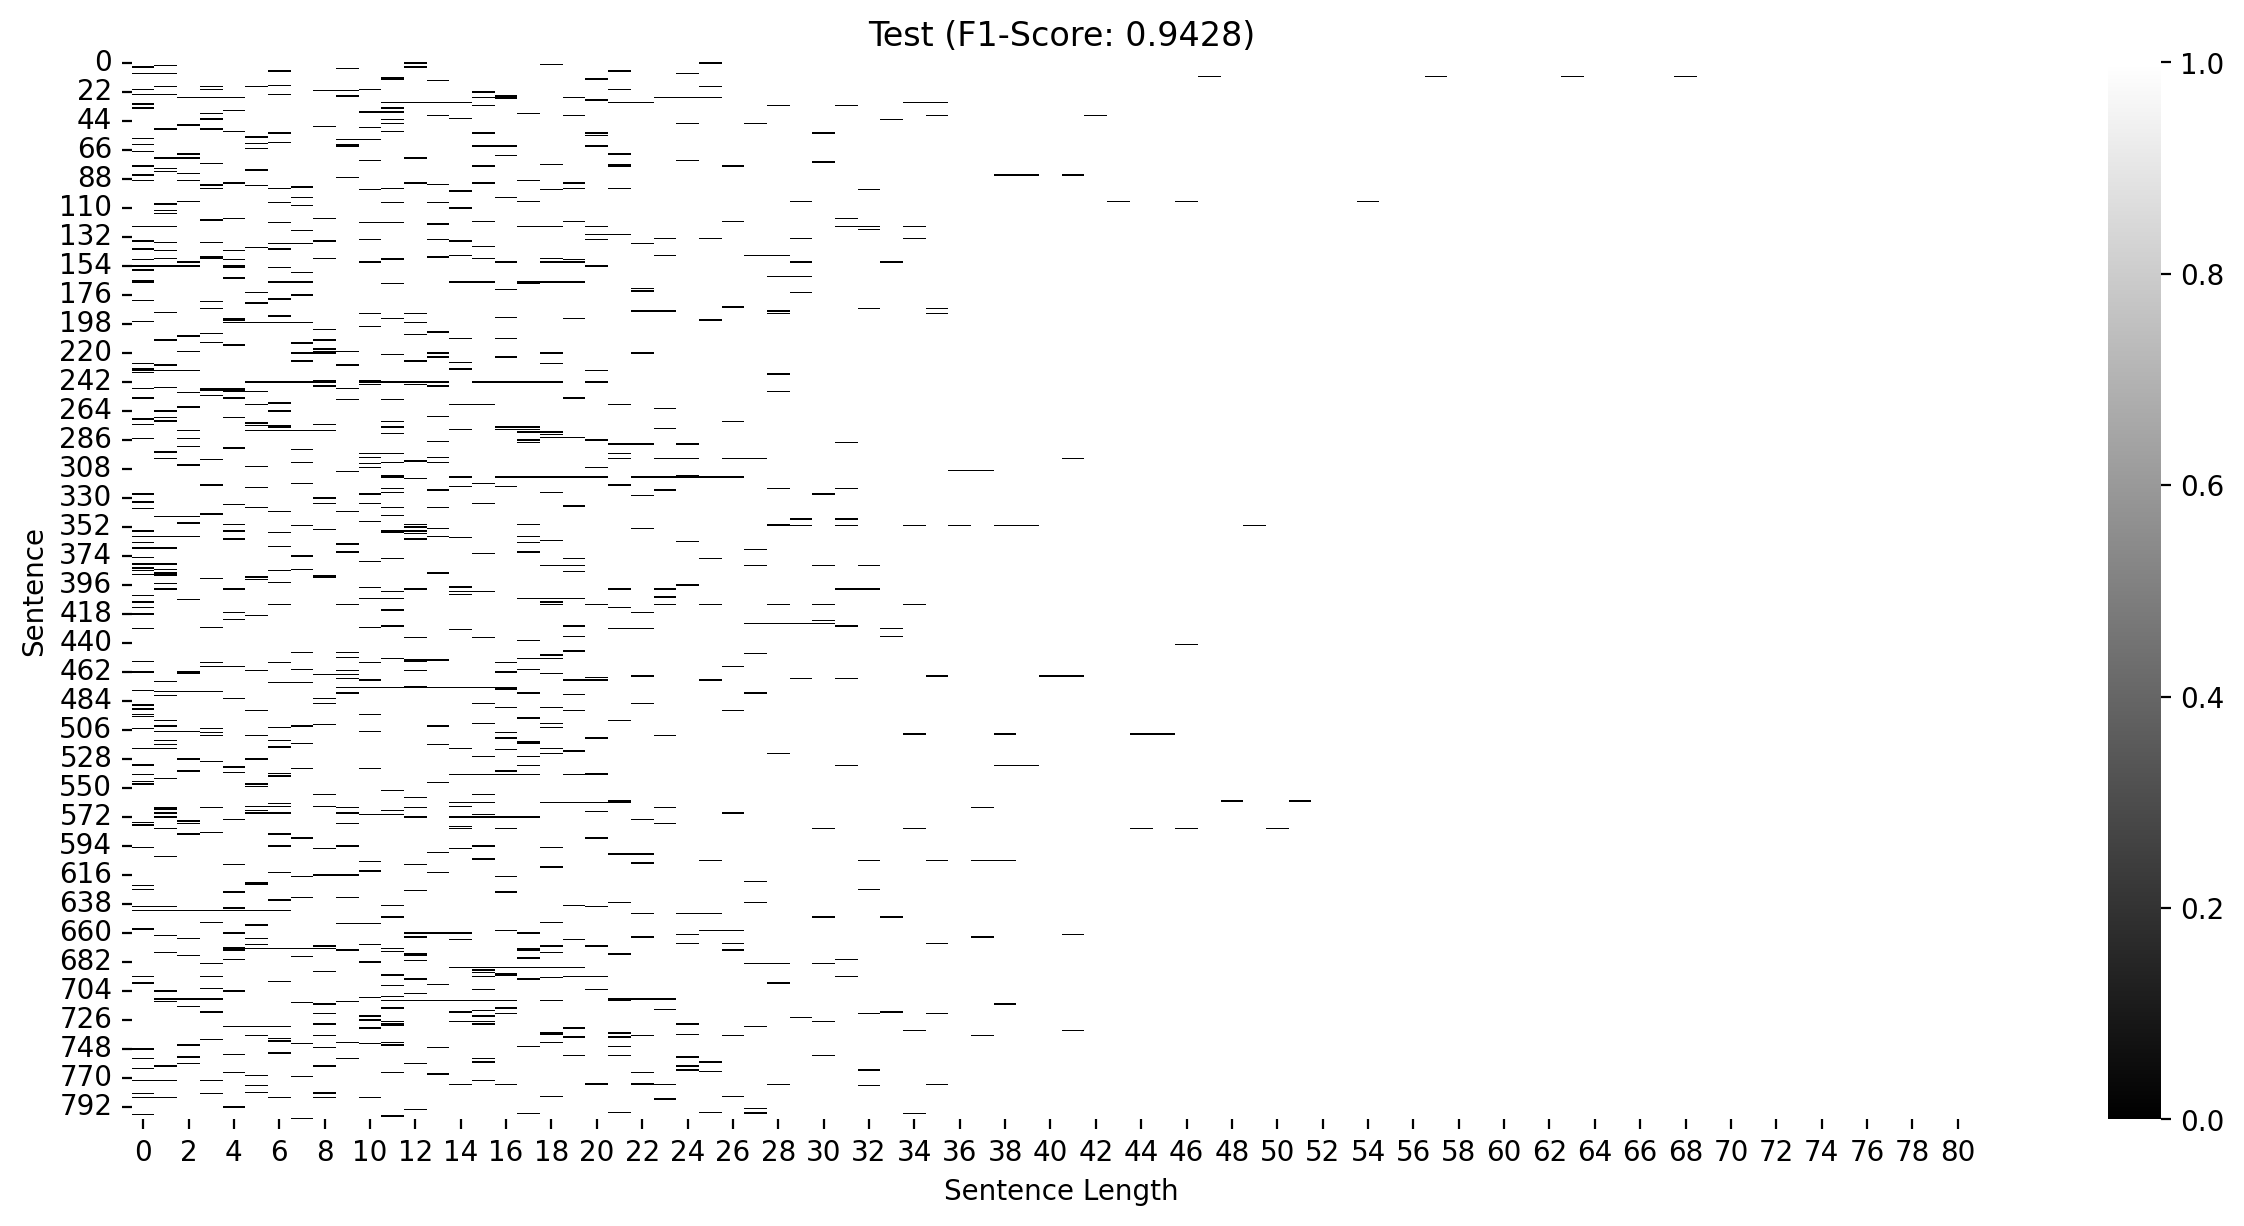

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


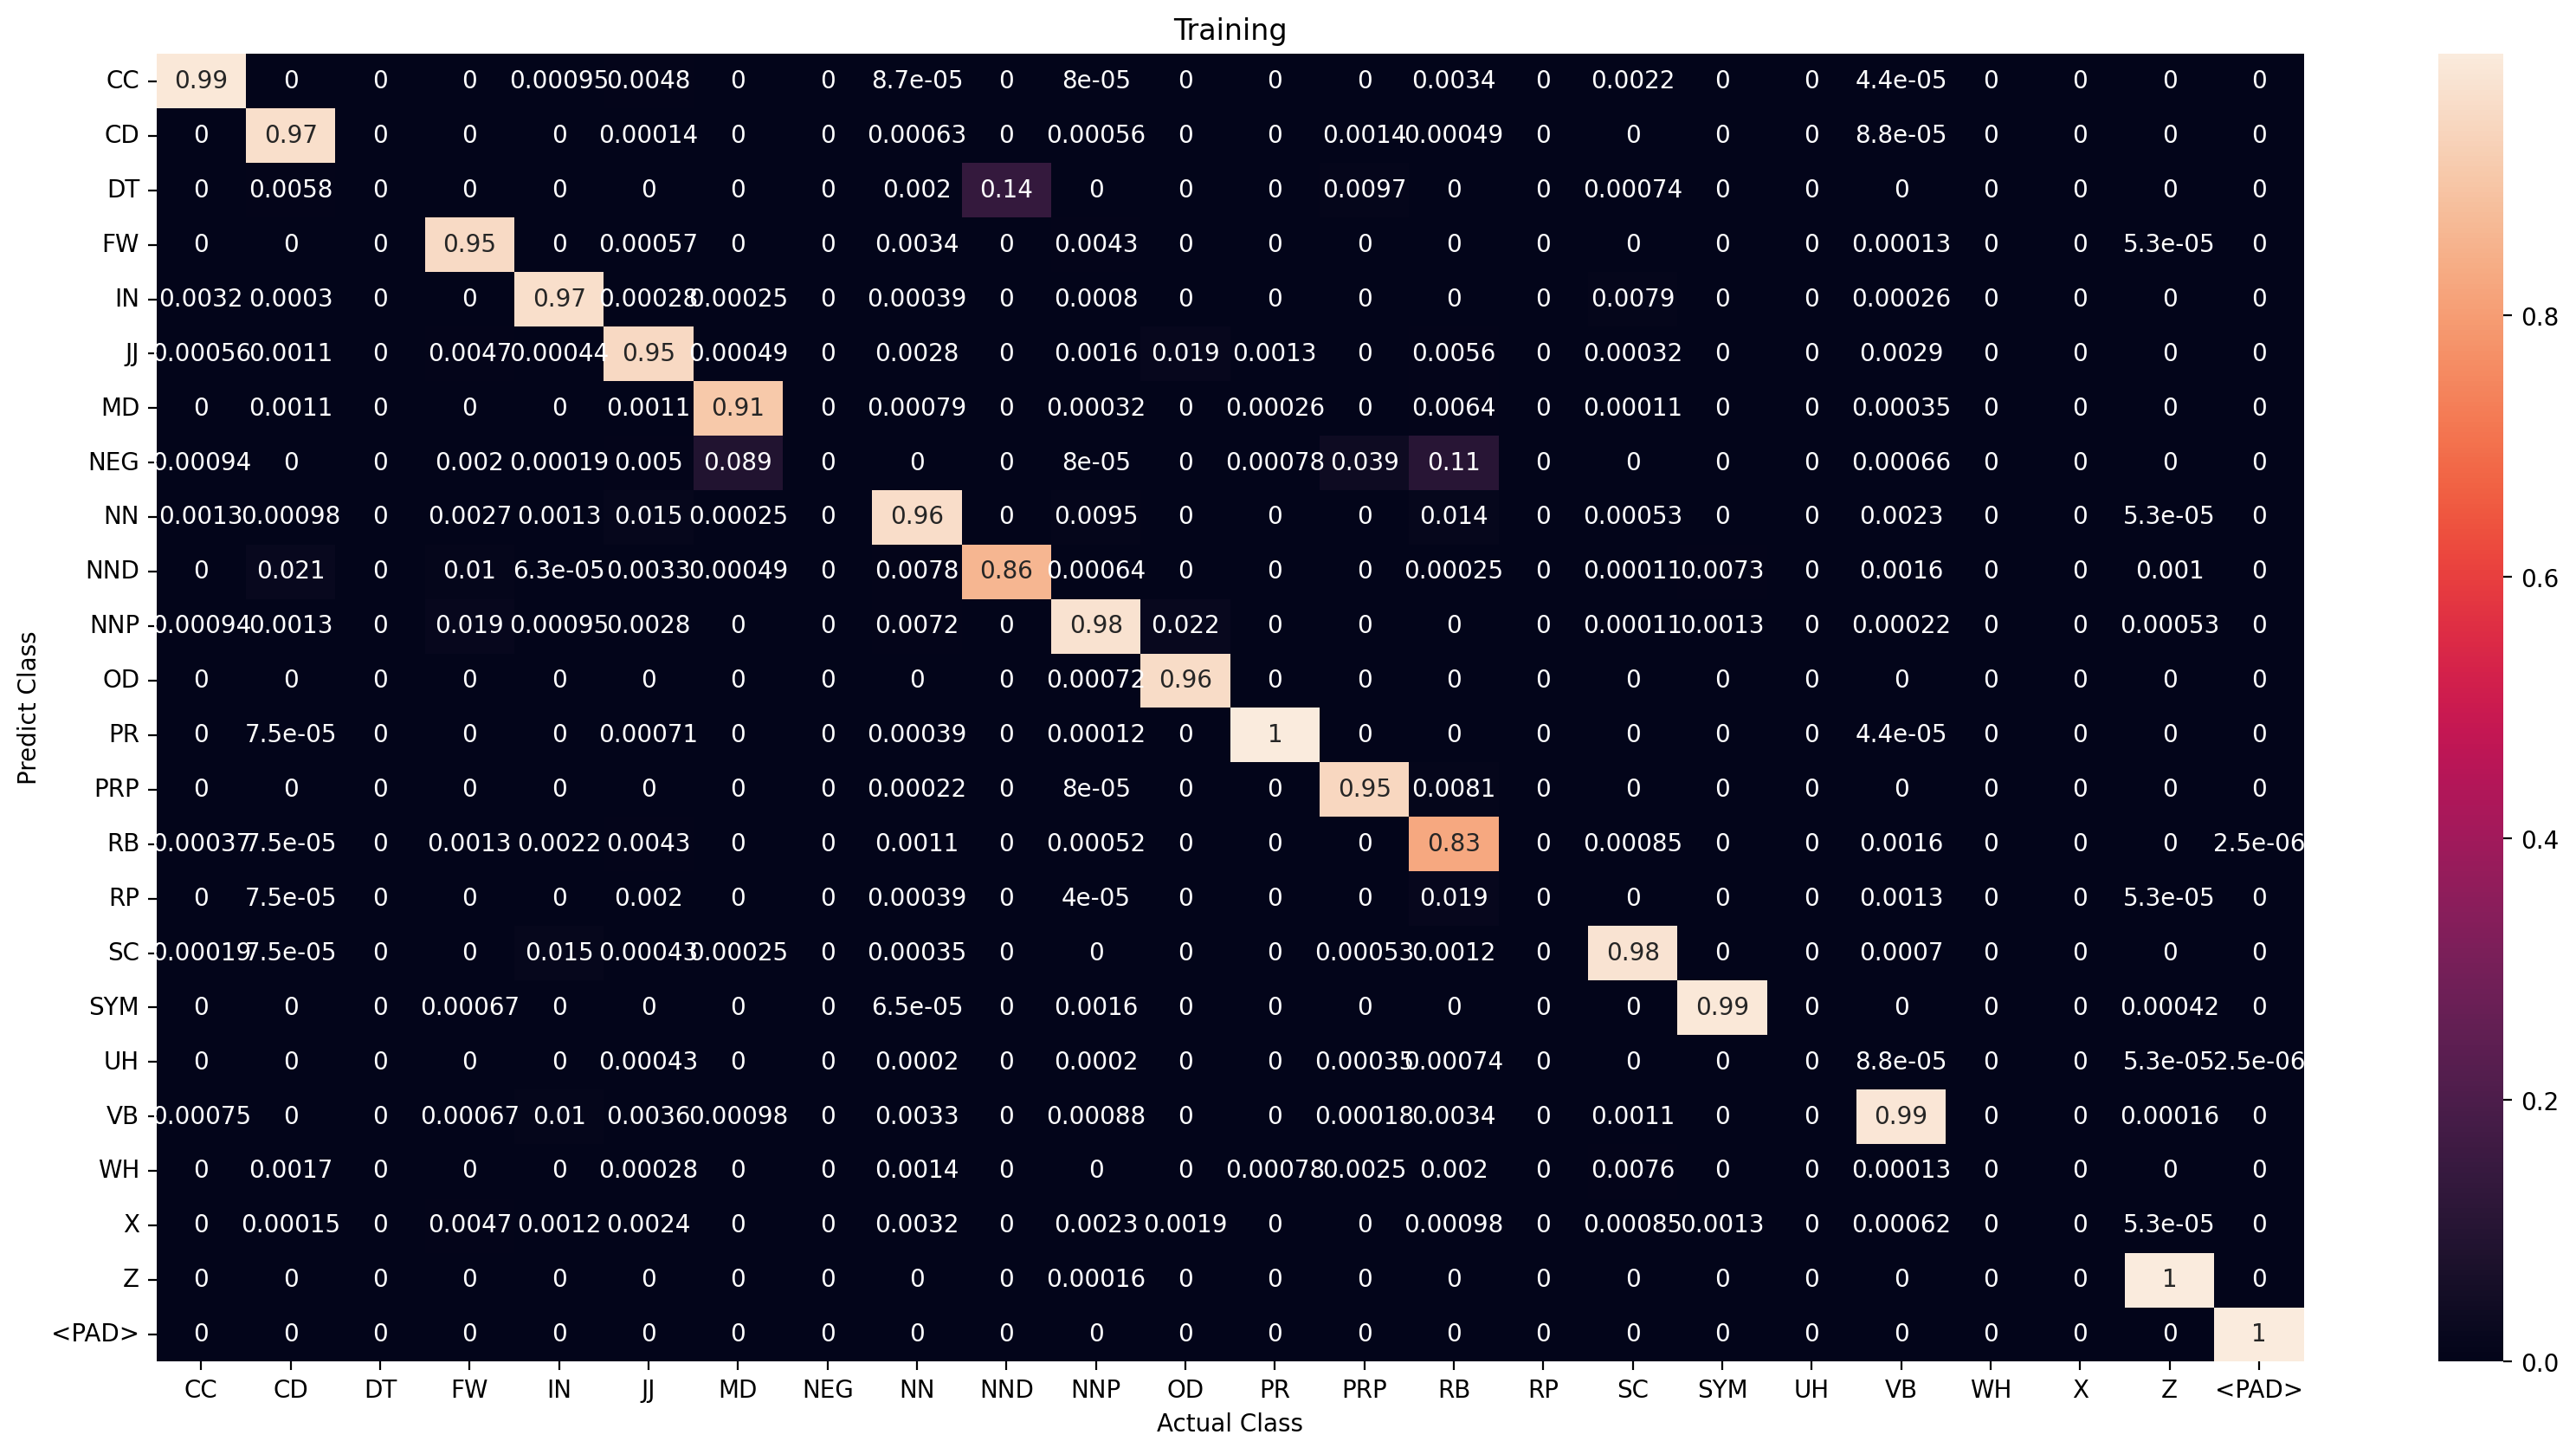

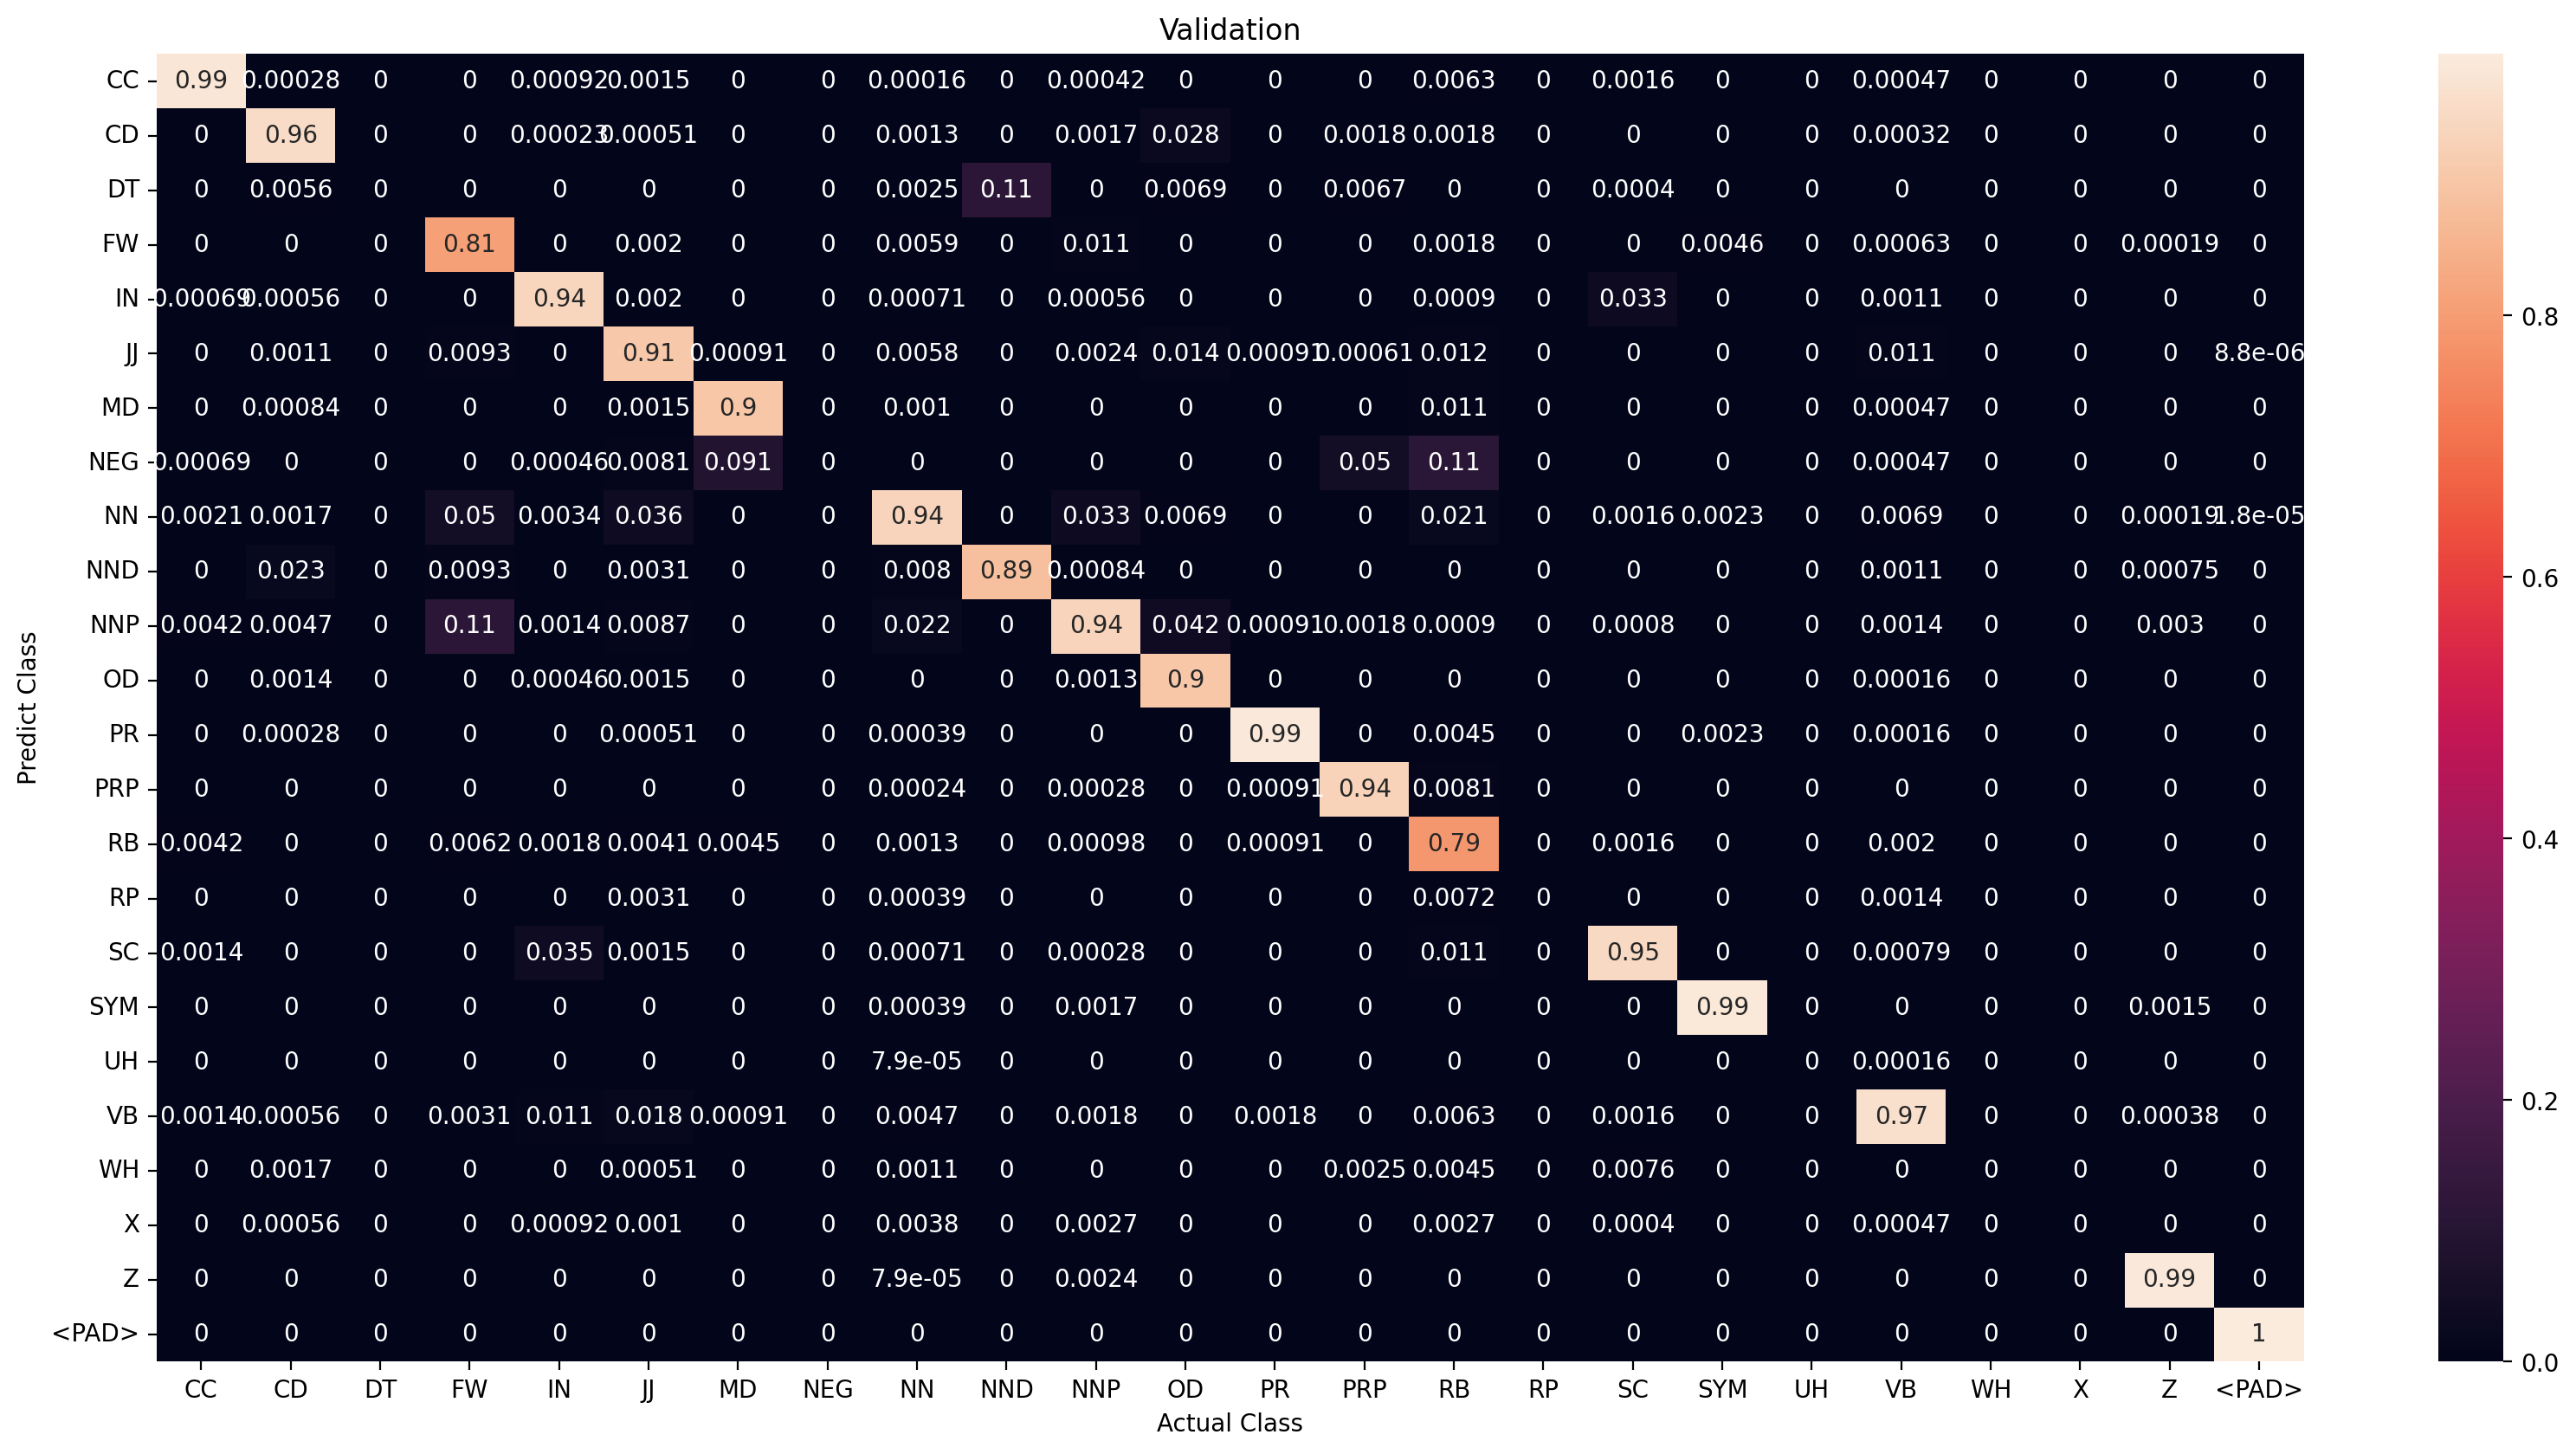

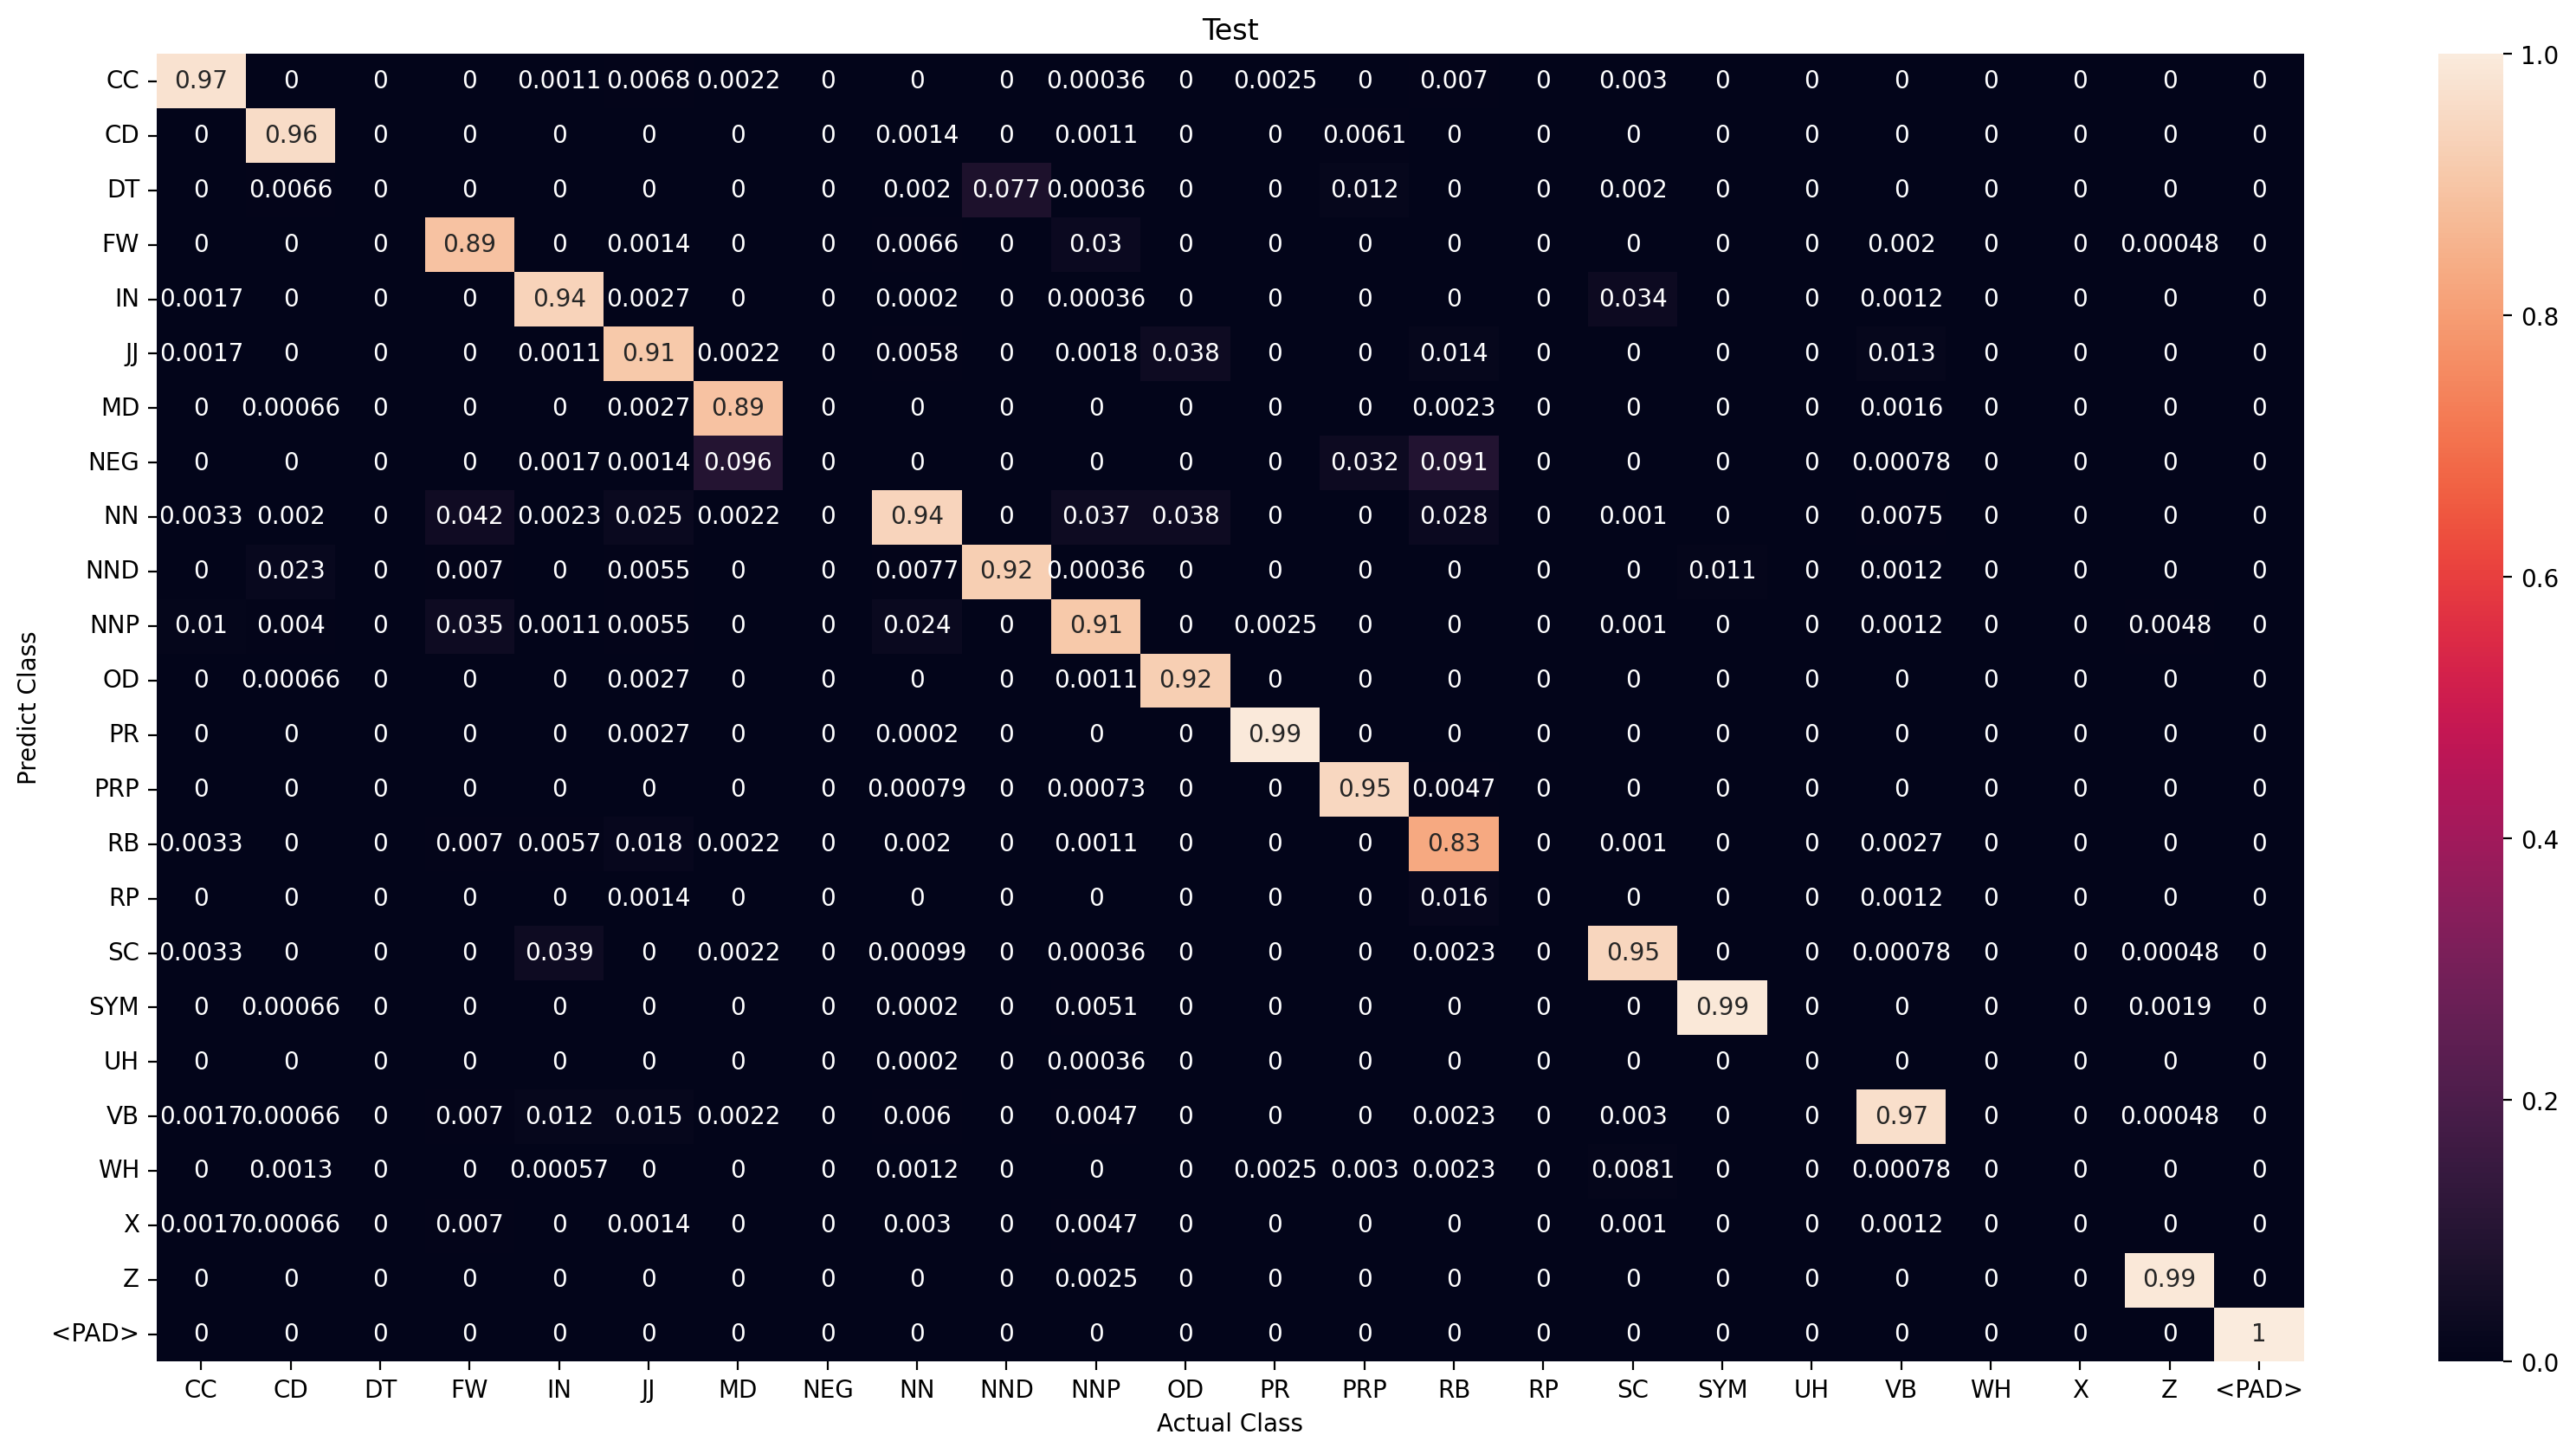

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5300       | CC    : 91       |
| CD    : 12882  | CD    : 12826      | CD    : 56       |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1420       | FW    : 270      |
| IN    : 15403  | IN    : 15261      | IN    : 142      |
| JJ    : 7018   | JJ    : 6709       | JJ    : 309      |
| MD    : 3810   | MD    : 3707       | MD    : 103      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44225      | NN    : 503      |
| NND   : 1019   | NND   : 260        | NND   : 759      |
| NNP   : 24885  | NNP   : 24437      | NNP   : 448      |
| OD    : 534    | OD    : 516        | OD    : 18       |
| PR    : 3842   | PR    : 3814       | PR    : 28       |
| PRP   : 5405   | PRP   : 5360       | PRP   : 45       |
| RB    : 3553   | RB    : 3376       | RB    : 177      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11249
Wrong prediction            : 559
Percentage correct oov pred : 95.26592140921409

Validation
Number OOV token            : 3395
Correct prediction          : 3050
Wrong prediction            : 345
Percentage correct oov pred : 89.83799705449191

Test
Number OOV token            : 1359
Correct prediction          : 1215
Wrong prediction            : 144
Percentage correct oov pred : 89.40397350993378



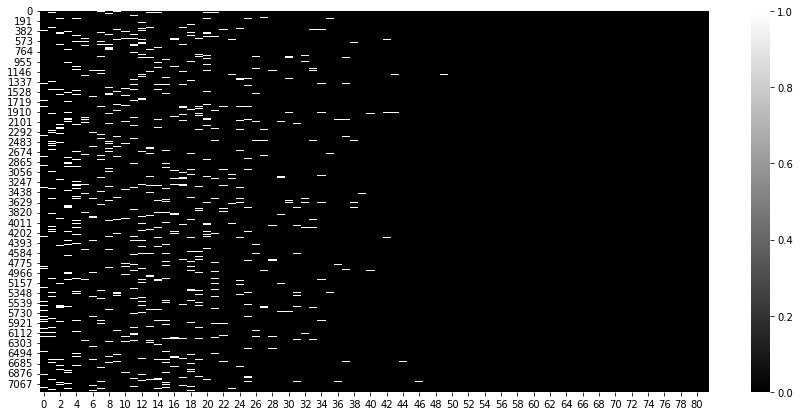

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

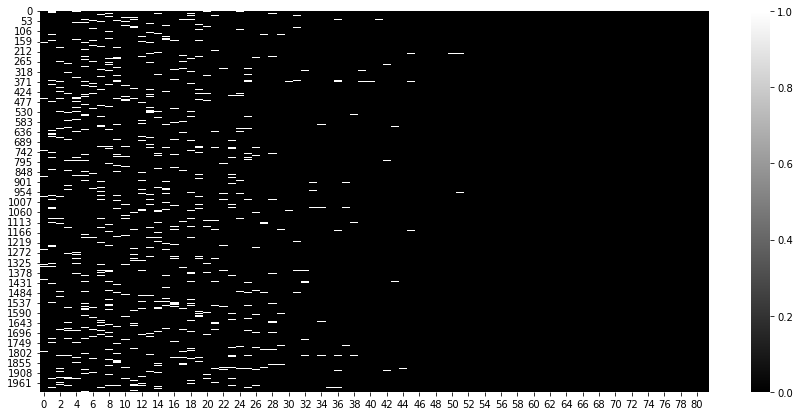

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

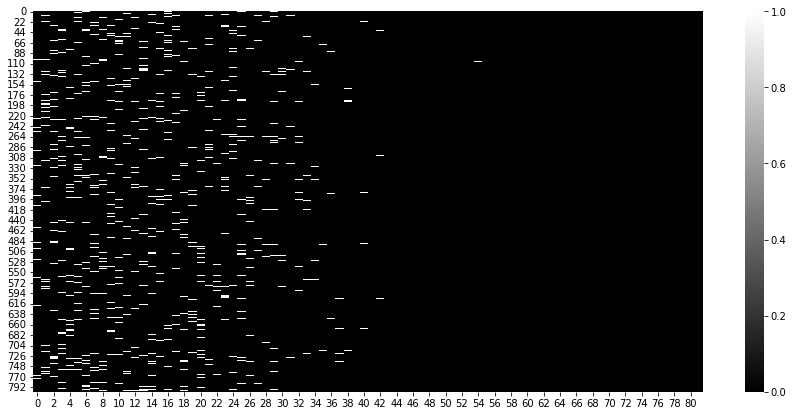

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);